# Distance Approximation

The original model of Rybski et al. requires the computation of the sum 

$$ \sum_{j} d_{ij}^{-\gamma} $$

for each location $i$, requiring the storage of the matrix $D = [d_{ij}]$ of distances. The size of the matrix $D$ scales badly with the simulation size. The matrix for a grid of side-length $L = 300$, for example, is $L^2 \times L^2 = 90,000 \times 90,000$, which is too large to fit into most laptops. 

In this notebook, we describe and test an approximation scheme that makes the computation of the complete set of weights tractable up to $L = 300$ or so on a laptop, and likely up to $L = 400$ on a larger machine with more RAM. 

# Initialize the Model

In [1]:
from urban_growth.model_refactor import *
from matplotlib import pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from scipy.spatial import distance
import cProfile
%matplotlib inline

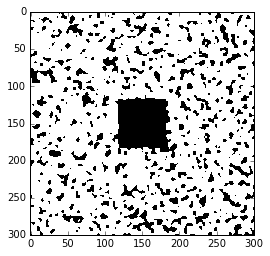

In [2]:
# Initial Configuration
L = 300
rho = .46
blur = 2

# Create the initial matrix and initialize a settlement_model object
M0 = random_mat(L, rho, blur = blur)
m = settlement_model(M0 = M0)

# Visualize the initial condition
plt.imshow(m.M0, interpolation = 'nearest', cmap = 'Greys')

# Outline of the Approximation

The aim here is to construct an approximation of the weighted distance summation calculation. The scheme works by considering each cluster $C$ separately. We aim to approximate the analytical Rybski sum for a specific point $i$ and cluster $C$, which is

$$ f(i,C) = \sum_{j \in C} d_{ij}^{-\gamma} \;.$$ 

We first compute the distance $r_0(i,C)$ of point $i$ to the nearest point in $C$, using the  `distance_transform_edt` function provided by `scipy.ndimage.morphology`. We then additionally compute the area $A(C)$ of cluster $C$.  

By approximating the cluster as a section of an annulus with inner radius $r_0(i,c)$, we can derive an analytical approximation of the Rybski sum as follows. First, under this approximation the area satisfies 

$$ A(C) = (r_1(i, C)^2 - r_0(i, c)^2) \theta(i,C) \;, $$

where $\theta(i,C)$ is the angle of the section and $r_1(i,C)$ the outer radius. We want to use this expression to solve for $r_1(i,C)$ and $\theta(i,C)$. To do this, we make the assumption that the annulus is "squarish:" specifically, that the inner circular side length is equal to the linear side-length. This entails $r_1(i,C) - r_0(i,C) \approx r_0(i,C) \theta(i,C)$, or 

$$\theta(i,C) \approx \frac{r_1(i,C) - r_0(i,C)}{r_0(i,C)}\;.$$

From this we can substitute for $\theta(i,C)$, obtaining that $r_1(i,C)$ is the largest positive real root of the cubic equation 

$$x^3 - r_0(i,C) x^2 - r_0(i,C)^2 x + r_0(i,C)^3 - A(C)r_0(i,C) = 0\;.$$

Finally, we obtain our approximation for the Rybski sum as:

$$f(i,C) = \sum_{j \in C} d_{ij}^{-\gamma} \approx \theta(i,C) \int_{r_0(i,C)}^{r_1(i,C)} r^{1-\gamma} \; dr = \theta(i,C) \frac{r_0(i,C)^{2 - \gamma} - r_1(i,C)^{2-\gamma}}{\gamma - 2} \;.$$

# An Informal Test

What we're going to do is to compute a bunch of analytic Rybski sums and a bunch of approximations above, and then plot them against each other. If they lie roughly on the line of equality, we are in good shape!

In [3]:
m.edt()
m.distance_variables() # only need to do this once (per simulation iteration)

urban_growth/helpers.py:32: RuntimeWarning: invalid value encountered in divide
  x = - 1 / (3.0 * a) * (b + C1 + d0 / C1)


In [4]:
def test_suite(gamma, n_iters):
    feature = m.distance_feature(gamma)
    
    def do_test():
        C_ix = np.random.choice(range(len(m.clusters))) + 1
        x    = np.random.choice(range(len(m.unsettled)))

        C = m.clusters[C_ix]
        x = m.unsettled[x]

        dists = distance.cdist(np.array([x]), C)
        true_sum = (dists ** ( - gamma)).sum()

        approx = feature[C_ix - 1][tuple(x)]
        return np.array([true_sum, approx])
    
    return np.array([do_test() for i in np.arange(n_iters)])

urban_growth/helpers.py:36: RuntimeWarning: divide by zero encountered in power
  return 2 * theta * (r_0 ** (2.0 - gamma) - r_1 ** (2.0 - gamma)) / (gamma - 2.0)
urban_growth/helpers.py:36: RuntimeWarning: divide by zero encountered in reciprocal
  return 2 * theta * (r_0 ** (2.0 - gamma) - r_1 ** (2.0 - gamma)) / (gamma - 2.0)


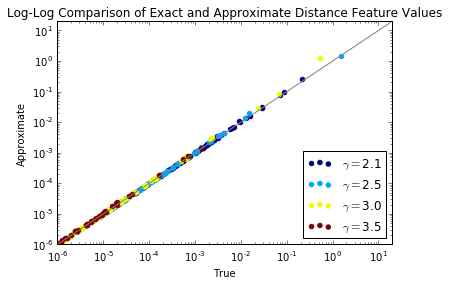

In [5]:
import matplotlib.cm as cmx
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([10**(-6), 20], [10**(-6), 20], color = 'grey')

for gamma in [2.1, 2.5, 3.0, 3.5]:
    x = test_suite(gamma, 100)

    ax.scatter(list(x[:,0]), 
               list(x[:,1]), 
               label = r'$\gamma = $' + str(gamma), 
               color = cmx.jet((gamma - 2.1) / 1.4))

ax.legend(loc = 4)
plt.title('Log-Log Comparison of Exact and Approximate Distance Feature Values')

opts = ax.set(xlabel = 'True', 
       ylabel = 'Approximate', 
       xlim = (10**(-6),20), 
       ylim = (10**(-6), 20),
       xscale = 'log',
       yscale = 'log')

Looks pretty good! 